In [3]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
#pd.set_option('max_rows',999)
pd.options.display.float_format = '{:.9f}'.format
import random
import itertools
from pathlib import Path
import re
import datetime
import dateutil
from multiprocessing import Pool
import matplotlib.pyplot as plt
from sklearn import linear_model
#import networkx as nx

from data_transform import file_to_transform, df_trades_resample, trades_files, trades2_transformed_files
root = Path("/home/daniele/Documenti/Progetti/TimeSeries/borsa/download_data")
from load_dfs import load_dfs, intersez_date, date_limite, max_intersection
#print(f"Root directory: {root}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
resampled_data_folder = Path("resampled")

# Gestione Dati

### Carico da file i dataframe ricampionati

In [5]:
df_list, coinpairs = load_dfs(resampled_data_folder, "df5min")

## Overlap massimo

In [6]:
range_tot = list(range(len(df_list)))
coppie_numeric = list(itertools.combinations(range_tot, 2))

In [7]:
inters = [intersez_date(df_list, i,j) for i, j in coppie_numeric]
print(max(inters))
best_ij = coppie_numeric[np.argmax(inters)]
best = date_limite(df_list, best_ij[0], best_ij[1])
print(best)

1418 days 11:05:00
(Timestamp('2021-06-25 15:05:00'), Timestamp('2017-08-07 04:00:00'))


In [8]:
lista_best_idx = []

try:
    range_tot.remove(best_ij[0])
    range_tot.remove(best_ij[1])
except:
    pass

In [9]:
lunghezze = []
while len(range_tot) > 1:
    inters_both = [max_intersection(df_list, best, i) for i in range_tot]
    inters = [a-b for a,b in inters_both]
    lungh = max(inters)
    #print(lungh)
    lunghezze.append(lungh)
    best_i = np.argmax(inters)
    best = max_intersection(df_list, best, range_tot[best_i])
    lista_best_idx.append(range_tot[best_i])
    range_tot.pop(best_i)

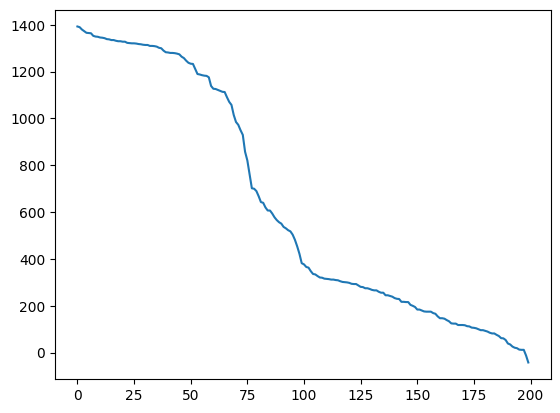

In [10]:
plt.plot([l.days for l in lunghezze])

### Scelgo un numero di crypto per massimizzare la finestra temporale

In [11]:
cut = 150
dfs = pd.concat([df_list[i] for i in lista_best_idx[:cut]], join='inner', axis=1)

In [12]:
#dfs = dfs2.copy()

In [13]:
# devo riempire i vuoti che ci sono negli intervalli privi di transazioni, ricopio il prezzo precedente
#dfs.fillna(0, inplace=True)
dfs = (dfs.ffill()+dfs.bfill())/2
for col in dfs.columns:
    dfs[col] = dfs[col].replace(to_replace=0, method='ffill')

In [14]:
coinpairs = [c.split('-')[0] for c in coinpairs]
dfs.columns = [coinpairs[i] for i in lista_best_idx[:cut]]